### Imports

In [1]:
import pandas as pd
import numpy as np
#from scipy import 
#from sklearn import
from datetime import datetime
import re
import datetime
# pd.set_option("display.max_rows", 100)
# from IPython.core.display import display
import matplotlib.pyplot as plt

### General variables

In [2]:
data_folder = '../../Data/'
print_text_result = False
raw_data_names = ['pit1_data-2022', 'pit2_data-2022', 'pit3_data-2022', 'pit4_data-2022',
                  'pit1_data-2023', 'pit2_data-2023', 'pit3_data-2023', 'pit4_data-2023']
clean_data_names = ['VII_PIT1_2022', 'VII_PIT2_2022', 'VII_PIT3_2022', 'VII_PIT4_2022']
df_pairs = [('pit1_data-2022', 'VII_PIT1_2022'), ('pit2_data-2022', 'VII_PIT2_2022'), ('pit3_data-2022', 'VII_PIT3_2022'), ('pit4_data-2022', 'VII_PIT4_2022'),
            ('pit1_data-2023', None), ('pit2_data-2023', None), ('pit3_data-2023', None), ('pit4_data-2023', None)]
col_types = ['int64', 'int64', 'int64', 'int64', 'int64', 'int64', 'int64', 'float64', 'int64', 'int64',
             'float64', 'int64', 'int64', 'float64', 'int64', 'int64', 'float64', 'int64', 'int64', 'float64',
             'int64', 'float64', 'float64', 'float64', 'float64', 'int64', 'float64', 'float64', 'float64', 'float64',
             'float64', 'float64', 'float64', 'float64', 'float64', 'int64', 'bool', 'bool', 'int64', 'float64',
             'float64', 'float64', 'float64', 'float64', 'float64', 'float64', 'bool']

### Helper functions

In [3]:

def print_result(header: str, init_count: int, new_count: int):
    print(header)
    print(f'\tinit row cnt: {init_count}')
    print(f'\t# of rows deleted: {init_count - new_count}')
    print(f'\tresult row count : {new_count}')

def remove_pit_suffix(name: str) -> str:
    """
    Remove suffix '_pit<number>' from header
    """
    re_match = re.search(r'_pit\d+$', name)
    if re_match:
        name = name[:re_match.start()]
    return name

def filter_dates(df: pd.DataFrame, file_name: str) -> int:
    init_row_cnt = len(df)
    start_date_2023 = datetime.datetime(2023, 1,1, 0, 0, 0)

    if '2022' in file_name:
        df.drop(df[df['TIMESTAMP'] >= start_date_2023].index, inplace=True)
    else:
        df.drop(df[df['TIMESTAMP'] < start_date_2023].index, inplace=True)

    if print_text_result: print_result('FILTERING DATES BY YEAR:', init_row_cnt, len(df))

    return (init_row_cnt - len(df))

def filter_duplicate_date(df: pd.DataFrame) -> int:
    init_row_cnt = len(df)
    
    df.drop_duplicates(subset='TIMESTAMP', inplace=True)

    if print_text_result: print_result('FILTERING DUPLICATE DATES:', init_row_cnt, len(df))

    return (init_row_cnt - len(df))

def filter_missing_values(df: pd.DataFrame, file_name: str, remove_empy=True) -> int:
    init_row_cnt = df.shape[0]
    if remove_empy and 'VII' not in file_name:
        df.dropna(inplace=True)
    # TODO else:
        # filter cleaned data
        # fill missing data

    if print_text_result: print_result('FILTERING MISSING VALUES:', init_row_cnt, len(df))

    return (init_row_cnt - len(df))

def filter_df(df: pd.DataFrame, file_name: str) -> dict:
    """
    Filters the given DataFrame by removing specific rows
    """
    diff_dict = dict()
    diff_dict['dates_removed'] = filter_dates(df, file_name)
    diff_dict['duplicates_removed'] = filter_duplicate_date(df)
    diff_dict['missing_data_removed'] = filter_missing_values(df, file_name)
    return diff_dict

def fix_types(df: pd.DataFrame, file_name: str) -> pd.DataFrame:
    """
    Fix data types from given DataFrame
    """
    if 'VII' in file_name:
        return df
    for col_type, col_name in zip(col_types, list(df.columns.array)[1:]):
        if col_type == 'int64':
            df[col_name] = df[col_name].astype('float64').astype('int64')
        elif col_type == 'float64':
            df[col_name] = df[col_name].astype('float64')
        else:
            df[col_name] = df[col_name].astype('bool')
    return df

def add_pit_column(df: pd.DataFrame, file_name: str) -> pd.DataFrame:
    if 'VII' in file_name:
        return df
    pit_n = file_name[3]
    df['pit_number'] = int(pit_n)
    return df

def merge_raw_cleaned(raw_dfs, clean_dfs, df_pairs: list[(str, str)] = df_pairs):
    merged_dfs = []
    for pair in df_pairs:
        raw = raw_dfs[pair[0]]
        if pair[1] is None:
            for x in range(1,6):
                raw[f'Redox_error_flag({x})'] = False
            raw['Redox_error_flag_available'] = False
            merged_dfs.append(raw)
        else:
            cleaned = clean_dfs[pair[1]]
            for x in range(1,6):
                cleaned[f'Redox_error_flag({x})'] = (cleaned['Redox_error_flag'] == True) | (cleaned[f'Redox_Avg({x})'].isna())
            cleaned = cleaned.drop(['Redox_error_flag'], axis=1)
            merged = raw.merge(
                cleaned[['TIMESTAMP', 'Redox_error_flag(1)', 'Redox_error_flag(2)', 'Redox_error_flag(3)', 'Redox_error_flag(4)', 'Redox_error_flag(5)']],
                how='left',
                left_on='TIMESTAMP',
                right_on='TIMESTAMP'
            )
            merged['Redox_error_flag_available'] = True
            merged_dfs.append(merged)
    return merged_dfs

def add_redox_log_cols(df: pd.DataFrame) -> pd.DataFrame:
    for x in range(1,6):
        df[f'log_redox({x})'] = np.log(df[f'Redox_Avg({x})'])
    return df

def load_data(file_names: list[str], data_folder: str) -> dict[str, pd.DataFrame]:
    """
    Load data from given file names
    :param file_names: list of file names
    :param data_folder: folder name where data is located
    :return: dictionary of DataFrames
    """
    dfs = dict()
    report_df = pd.DataFrame()

    for file_name in file_names:
        df = pd.read_csv(data_folder+file_name+'.csv', parse_dates=['TIMESTAMP'])
        df.rename(mapper=remove_pit_suffix, axis='columns', inplace=True)
            
        if print_text_result: print(f'===== {file_name} =====')

        stats = filter_df(df, file_name)
        # TODO add log scale to redox and error flag for each redox depth
        df = fix_types(df, file_name)
        df = add_pit_column(df, file_name)
        df = add_redox_log_cols(df)
        report_df = pd.concat([report_df, pd.DataFrame(stats, index=[file_name])])
        dfs[file_name] = df

        if print_text_result: print('\n')

    report_df = report_df.assign(Total = lambda x: (x.sum(axis=1)))
    print(report_df)

    return dfs

### Load data

In [4]:
raw_data = load_data(raw_data_names, data_folder)
clean_data = load_data(clean_data_names, data_folder)

/tmp/ipykernel_11576/1407515731.py:1: DtypeWarning: Columns (34,37) have mixed types.Specify dtype option on import or set low_memory=False.
  raw_data = load_data(raw_data_names, data_folder)
/usr/lib/python3/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib/python3/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_11576/1407515731.py:1: DtypeWarning: Columns (34) have mixed types.Specify dtype option on import or set low_memory=False.
  raw_data = load_data(raw_data_names, data_folder)
/tmp/ipykernel_11576/1407515731.py:1: DtypeWarning: Columns (37) have mixed types.Specify dtype option on import or set low_memory=False.
  raw_data = load_data(raw_data_names, data_folder)
/tmp/ipykernel_11576/1407515731.py:1: DtypeWarning: Columns (7,8,9,34,37) have mixed types.Specify d

                dates_removed  duplicates_removed  missing_data_removed  Total
pit1_data-2022              1                  12                   267    280
pit2_data-2022              1                  24                  4348   4373
pit3_data-2022              1                  12                   167    180
pit4_data-2022              1                  12                   125    138
pit1_data-2023            287                  15                   279    581
pit2_data-2023           3248               25552                  7215  36015
pit3_data-2023            287                  88                   279    654
pit4_data-2023            287                 196                  1143   1626


/tmp/ipykernel_11576/1407515731.py:2: DtypeWarning: Columns (37,38,47) have mixed types.Specify dtype option on import or set low_memory=False.
  clean_data = load_data(clean_data_names, data_folder)
/usr/lib/python3/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib/python3/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_11576/1407515731.py:2: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  clean_data = load_data(clean_data_names, data_folder)
/tmp/ipykernel_11576/1407515731.py:2: DtypeWarning: Columns (37,47) have mixed types.Specify dtype option on import or set low_memory=False.
  clean_data = load_data(clean_data_names, data_folder)


               dates_removed  duplicates_removed  missing_data_removed  Total
VII_PIT1_2022              1                 192                     0    193
VII_PIT2_2022              1                  24                     0     25
VII_PIT3_2022              1                  12                     0     13
VII_PIT4_2022              1                  12                     0     13


### Check data

In [5]:
raw_data['pit1_data-2022'].head()

,TIMESTAMP,RECORD,Redox_Avg(1),Redox_Avg(2),Redox_Avg(3),Redox_Avg(4),Redox_Avg(5),CCVWC_Avg(1),Temp_T12_Avg(1),EC_Avg(1),...,WC2,WC3,WC4,WC5,pit_number,log_redox(1),log_redox(2),log_redox(3),log_redox(4),log_redox(5)
0,2022-04-12 09:00:00,31570,138,301,176,84,61,2404,0.2,79,...,0.393623,0.435904,0.458790,0.504951,1,4.927254,5.707110,5.170484,4.430817,4.110874
1,2022-04-12 09:05:00,31571,138,301,176,84,61,2405,0.2,79,...,0.393623,0.435904,0.458402,0.504563,1,4.927254,5.707110,5.170484,4.430817,4.110874
2,2022-04-12 09:10:00,31572,138,301,176,84,61,2405,0.2,80,...,0.393623,0.435904,0.458402,0.504951,1,4.927254,5.707110,5.170484,4.430817,4.110874
3,2022-04-12 09:15:00,31573,138,302,175,84,61,2405,0.2,80,...,0.394011,0.435904,0.458790,0.504951,1,4.927254,5.710427,5.164786,4.430817,4.110874
4,2022-04-12 09:20:00,31574,138,301,175,84,61,2405,0.2,80,...,0.393623,0.435904,0.458790,0.504951,1,4.927254,5.707110,5.164786,4.430817,4.110874


### Dtypes in each dataframe

    NOTE: Cleaned data dtypes not changed yet. Need to think how to deal with missing values for column which should be converted to int64 from original float64

In [6]:
i = 1
print('\t\t\t'+'1\t\t'+'\t'.join(str(a) for a in [*range(2,49)]))
for t1 in zip([*raw_data.items(), *clean_data.items()]):
    print(f'{t1[0][0]}\t{i}\t'+'\t'.join(str(x) for x in t1[0][1].dtypes.array))
    i +=1

			1		2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48
pit1_data-2022	1	datetime64[ns]	int64	int64	int64	int64	int64	int64	int64	float64	int64	int64	float64	int64	int64	float64	int64	int64	float64	int64	int64	float64	int64	float64	float64	float64	float64	int64	float64	float64	float64	float64	float64	float64	float64	float64	float64	int64	bool	bool	int64	float64	float64	float64	float64	float64	float64	float64	int64	float64	float64	float64	float64	float64
pit2_data-2022	2	datetime64[ns]	int64	int64	int64	int64	int64	int64	int64	float64	int64	int64	float64	int64	int64	float64	int64	int64	float64	int64	int64	float64	int64	float64	float64	float64	float64	int64	float64	float64	float64	float64	float64	float64	float64	float64	float64	int64	bool	bool	int64	float64	float64	float64	float64	float64	float64	float64	int64	float64	float64	float64	float64	float64
pit3_data-2022	3	datetime64[ns]	int64	int64	int64	int64	i

### Add redox error flag columns and merge them with raw data

In [7]:
merged_dfs = merge_raw_cleaned(raw_data, clean_data, df_pairs)

### Combine all raw data

In [8]:
all_raw_data_df = pd.DataFrame()
for df in merged_dfs:
    all_raw_data_df = pd.concat([all_raw_data_df, df], ignore_index=True)

### Add the standard deviation features 

(timestamp_gap, calculate_backward_sigma, sigma_feature_engineering,print_high_level_std_dev_error_flag_interplay)

In [9]:
def timestamp_gap(df: pd.DataFrame, timedelta: datetime.timedelta, print_stats_graphs: bool) -> tuple: 
    
    df["TIMESTAMP_DIFF"] = datetime.timedelta(0,0,0,0,0,0,0)
    
    breaks = dict()
    gaps = dict() 

    pits = np.unique(df["pit_number"])
    
    for i in pits:
        df.loc[df["pit_number"]==i,"TIMESTAMP_DIFF"] = df.loc[df["pit_number"]==i,"TIMESTAMP"].diff()
    
    # it's the check that all the timestamps are already sorted in a DataFrame, if not then they first have to be sorted
    # the first observation has NA as there are no observations prior to it
           
    assert(np.all((df["TIMESTAMP_DIFF"].dt.total_seconds() > 0) | (np.isnan(df["TIMESTAMP_DIFF"]))))
    
      
    for i in pits:
        breaks[i] = list(df[df["pit_number"]==i].index[(df.loc[df["pit_number"]==i, "TIMESTAMP_DIFF"] != timedelta) & (np.isnan(df.loc[df["pit_number"]==i, "TIMESTAMP_DIFF"]) == False)])
        gaps[i] = [int(df[df["pit_number"]==i].loc[index, "TIMESTAMP_DIFF"].total_seconds()/60) for index in breaks[i]]
         
        gaps_observations = pd.DataFrame([[index, gap] for index, gap in zip(breaks[i], gaps[i])])
        gaps_observations.columns = ["Observation index", "Time delta (min)"]
        
        if print_stats_graphs == True:
            
            print(f"For the pit {i} the observations having gaps")
            print(gaps_observations)

    if print_stats_graphs == True:
        fig, axes = plt.subplots(2,2, figsize = (10,12))

        for i in pits:
            axes[int((i-1)/2), int(i-1)%2].bar(np.unique(gaps[i], return_counts=True)[0].astype("str"), height = np.unique(gaps[i], return_counts=True)[1])
            axes[int((i-1)/2), int(i-1)%2].set_title(f"Distribution of dt for pit {i} (in min)")

        fig.set_tight_layout(True)
        plt.show()
    
    return (breaks, gaps)

For the pit 1 the observations having gaps
   Observation index  Time delta (min)
0              47113              1530
1              48142               620
2              70479               640
3             223955              1835
4             225842              2090
For the pit 2 the observations having gaps
   Observation index  Time delta (min)
0              75370                15
1             131565                15
2             330849              2010
3             351741                15
4             361283             34345
5             377703               665
6             385097               475
For the pit 3 the observations having gaps
   Observation index  Time delta (min)
0             148523               840
1             460080               940
2             489939               470
For the pit 4 the observations having gaps
   Observation index  Time delta (min)
0             174043               620
1             175754              2045
2        

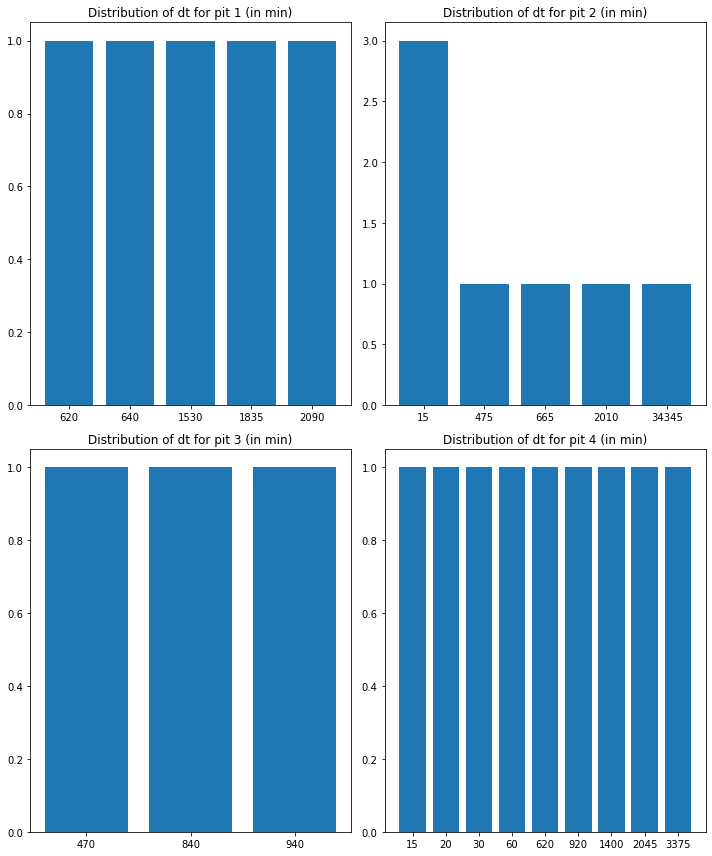

In [10]:
timedelta = datetime.timedelta(days = 0, hours = 0, minutes = 5, seconds = 0, milliseconds= 0, weeks = 0)
breaks, gaps = timestamp_gap(all_raw_data_df, timedelta, print_stats_graphs = True)

In [11]:
def calculate_backward_sigma(rolling_window: pd.DataFrame, breaks: list, window_size: int, starting_index: int):
    
    if rolling_window.index[-1] < starting_index + 4:
        return([np.nan, np.nan, np.nan, np.nan, np.nan])
    for j in breaks:
        if (rolling_window.index[-1] - j >=0) and (rolling_window.index[-1] - j < window_size - 1):
            return([np.nan, np.nan, np.nan, np.nan, np.nan])
    return rolling_window[["Redox_Avg(1)",	"Redox_Avg(2)",	"Redox_Avg(3)",	"Redox_Avg(4)",	"Redox_Avg(5)"]].apply(func = np.std, axis = 0)


def sigma_feature_engineering(df: pd.DataFrame, window_size, print_sigma_statistics = True):
    
    pits = np.unique(df["pit_number"])
    breaks = timestamp_gap(df, timedelta, print_stats_graphs = False)[0]
    
    for column in ["Redox_Avg(1)",	"Redox_Avg(2)",	"Redox_Avg(3)",	"Redox_Avg(4)",	"Redox_Avg(5)"]:
        df[column + "_sigma_b"] = np.nan
        df[column + "_sigma_f"] = np.nan
    
    removed_rows = dict()

    sigma_col_names_list = ["Redox_Avg(1)_sigma_b",	"Redox_Avg(2)_sigma_b",	"Redox_Avg(3)_sigma_b",	"Redox_Avg(4)_sigma_b",	"Redox_Avg(5)_sigma_b", "Redox_Avg(1)_sigma_f",	"Redox_Avg(2)_sigma_f",	"Redox_Avg(3)_sigma_f",	"Redox_Avg(4)_sigma_f",	"Redox_Avg(5)_sigma_f"]
    
    for i in pits:
        
        pit_data = df[df["pit_number"]== i]
    
        backward_sigma = np.array([calculate_backward_sigma(rolling_window, breaks = breaks[i], window_size = window_size, starting_index = pit_data.index[0]) for rolling_window in pit_data.rolling(window_size)])

        df.loc[df["pit_number"]==i,["Redox_Avg(1)_sigma_b",	"Redox_Avg(2)_sigma_b",	"Redox_Avg(3)_sigma_b",	"Redox_Avg(4)_sigma_b",	"Redox_Avg(5)_sigma_b"]] = backward_sigma
        
        forward_sigma = df.loc[df["pit_number"]==i,["Redox_Avg(1)_sigma_b",	"Redox_Avg(2)_sigma_b",	"Redox_Avg(3)_sigma_b",	"Redox_Avg(4)_sigma_b",	"Redox_Avg(5)_sigma_b"]].shift(-(window_size-1))
        df.loc[df["pit_number"]==i,["Redox_Avg(1)_sigma_f",	"Redox_Avg(2)_sigma_f",	"Redox_Avg(3)_sigma_f",	"Redox_Avg(4)_sigma_f",	"Redox_Avg(5)_sigma_f"]] = forward_sigma.to_numpy()

        if print_sigma_statistics == True:
            if i == pits[0]:
                print(f"Standard deviation statistics are calculated for the window size {window_size}")
            print(f"\n standard deviation statistics for the pit {i}\n")
            print(df.loc[df["pit_number"]==i,["Redox_Avg(1)_sigma_b", "Redox_Avg(2)_sigma_b", "Redox_Avg(3)_sigma_b", "Redox_Avg(4)_sigma_b", "Redox_Avg(5)_sigma_b"]].apply([min, max, np.mean, np.median], axis = 0).to_string())

        rows_to_be_removed = df[df["pit_number"]== i].index[np.any(df.loc[df["pit_number"]== i, sigma_col_names_list].isna(), axis = 1)]
        removed_rows[i] = rows_to_be_removed
    
        df.drop(removed_rows[i], axis = "index", inplace = True)

    print(f"{sum([len(n_i) for n_i in removed_rows.values()])} rows had to be removed due to \" hitting \" time gaps or margin areas when calculating standard deviation")
    
    return (df, removed_rows)

In [12]:
# here the sigma feature is added to the DataFrame - the number of observations for sigma calculation can be chosen by passing it as a parameter  
all_raw_data_df, removed_rows = sigma_feature_engineering(all_raw_data_df, window_size = 5, print_sigma_statistics = True)

Standard deviation statistics are calculated for the window size 5

 standard deviation statistics for the pit 1

        Redox_Avg(1)_sigma_b  Redox_Avg(2)_sigma_b  Redox_Avg(3)_sigma_b  Redox_Avg(4)_sigma_b  Redox_Avg(5)_sigma_b
min                 0.000000              0.000000              0.000000              0.000000              0.000000
max               494.211048            263.617602            254.842697            260.991647            344.524948
mean                0.462953              0.316249              0.357501              0.387272              0.429105
median              0.000000              0.000000              0.000000              0.000000              0.000000

 standard deviation statistics for the pit 2

        Redox_Avg(1)_sigma_b  Redox_Avg(2)_sigma_b  Redox_Avg(3)_sigma_b  Redox_Avg(4)_sigma_b  Redox_Avg(5)_sigma_b
min                 0.000000              0.000000              0.000000              0.000000              0.000000
max               45

In [13]:
def print_high_level_std_dev_error_flag_interplay(df: pd.DataFrame, threshold: float, pit_num: np.array = [1], sensor_num: list = [1], only_backward: bool = True):
    
    for k in pit_num:
        
        df_ = df[df["pit_number"]==k]
        
        print(f"data for pit {k}")
        
        print("-----------------------")
        
        for l in sensor_num:
            
            print(f"data for sensor {l}")
            redox_error_col_name = "Redox_error_flag(" + str(l) + ")"
            redox_f_sigma_col_name = "Redox_Avg(" + str(l) + ")_sigma_b"
            redox_b_sigma_col_name = "Redox_Avg(" + str(l) + ")_sigma_f"

            print(f"number of error flags {sum(df_[redox_error_col_name] == True)}")
            print(f"number of observations total {df_.shape[0]}")
            
            if only_backward == False:
                print(f"number of observations with at least one sigma greater than {threshold} and error flag {sum(((df_[redox_b_sigma_col_name]> threshold) | (df_[redox_f_sigma_col_name]> threshold)) & (df_[redox_error_col_name] == True))}")
                print(f"number of observations with at least one sigma greater than {threshold} {sum((df_[redox_b_sigma_col_name]> threshold) | (df_[redox_f_sigma_col_name]> threshold))}")
            else:
                print(f"number of observations with backward standard deviation greater than {threshold} and error flag {sum((df_[redox_b_sigma_col_name]> threshold) & (df_[redox_error_col_name] == True))}")
                print(f"number of observations with backward standard deviation greater than {threshold} {sum(df_[redox_b_sigma_col_name]> threshold)}")



In [14]:
print_high_level_std_dev_error_flag_interplay(all_raw_data_df, threshold = 2, pit_num = np.unique(df["pit_number"]), sensor_num = [1], only_backward = False)

data for pit 4
-----------------------
data for sensor 1
number of error flags 1
number of observations total 131021
number of observations with at least one sigma greater than 2 and error flag 1
number of observations with at least one sigma greater than 2 10782


### Save data to a CSV file

In [15]:
training_folder_path = f'{data_folder}/Training/'
all_raw_data_df.to_csv(f'{training_folder_path}Raw_training_data_full.csv')